![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [5]:
# Celda 1.1
descrip_workinggay=bikes.groupby('workingday').total

In [6]:
print(descrip_workinggay.describe())

             count        mean         std  min   25%    50%    75%    max
workingday                                                                
0           3474.0  188.506621  173.724015  1.0  44.0  128.0  304.0  783.0
1           7412.0  193.011873  184.513659  1.0  41.0  151.0  277.0  977.0


## Análisis descriptivo variable workingday

Workingday es una variable categorica, con valores de 0 y 1, donde 0 es si el dia no es laboral (fines de semana o feriado) , y 1 en caso contrario

Al analizarla con el numero de alquieres totales, tenemos que:

* En dia no laborales se tuvieron 3.474 observaciones, mientras que en dia laborales, 7.412 observaciones.
* En cuanto al promedio de alquileres por dia, para los no laborales fue de 188.5, mientras que para los dias laborales fue de 193.01
* La desviación estandar de estas agrupaciones fue de 173.72 para los dias no laborales y de 184.51 para los dias laborales, dispercion que concuerda con la cantidad de observaciones de cada agrupación. 
* El minimo para ambas observaciones fue de 1 alquiler, mientras que el maximo para los dias no laborales fue de 783 alquileres,  por otro lado, para los dias laborales, el maximo registrado de alquileres fue de 977. 

In [7]:
# Celda 1.2
descrip_hour=bikes.groupby('hour').total

In [8]:
print(descrip_hour.describe())

      count        mean         std   min     25%    50%     75%    max
hour                                                                   
0     455.0   55.138462   43.620012   2.0   24.00   41.0   74.50  283.0
1     454.0   33.859031   34.112105   1.0   11.00   19.0   46.00  168.0
2     448.0   22.899554   26.110267   1.0    5.00   11.0   32.00  119.0
3     433.0   11.757506   12.666442   1.0    3.00    6.0   15.00   66.0
4     442.0    6.407240    4.217633   1.0    3.00    6.0    9.00   28.0
5     452.0   19.767699   12.784293   1.0    8.00   19.0   29.00   57.0
6     455.0   76.259341   54.745333   1.0   24.50   75.0  118.00  213.0
7     455.0  213.116484  159.207044   1.0   63.00  208.0  334.00  596.0
8     455.0  362.769231  231.723065   8.0  133.50  392.0  563.50  839.0
9     455.0  221.780220   92.099209  14.0  161.00  217.0  294.50  414.0
10    455.0  175.092308  101.807629  17.0  106.00  149.0  218.50  539.0
11    455.0  210.674725  127.444294  10.0  123.00  183.0  265.50

## Análisis descriptivo variable hour

Hour es una variable categórica, que describe la hora del dia en que fue alquilada o alquiladas la o las bicicletas.

Al analizarla con el numero de alquieres totales, tenemos que:

* El numero de observaciones por hora varia entre 433 y 456.
* En cuanto al promedio de alquileres por hora, tenemos que se presentan mayormente entre las 5 y 6 de la tarde, con 468.76 y 430,85 alquileres en promedio en esas horas respectivamente. Por otro lado, las horas en las que menos alquieres en promedio se presentan son entre las 2 y 4 de la mañana. 
* El minimo de alquileres que se presenta es de 1, mientras que el maximo de alquileres presentado es de 977 a las 6 de la tarde, seguido de 970 a las 5 de la tarde.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

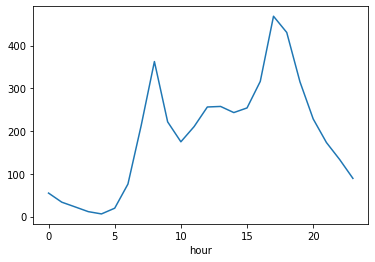

In [9]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

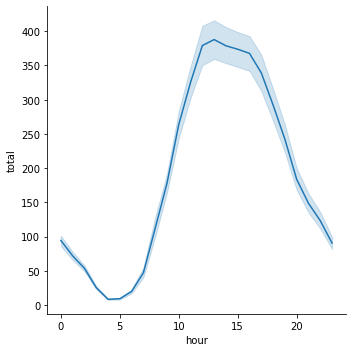

In [10]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
sns.relplot(
    data=bikes[bikes.workingday == 0], 
    x="hour", y="total", 
    kind="line"
)

## Análisis grafico "workingday"=0

Al analizar el numero de alquileres por hora, cuando el dia no es laboral, tenemos que en promedio, entre las 12 y las 5 de la tarde son los periodos en que mas se alquilan bicicletas, mientras que entre las 12 y las 7 de la mañana son los periodos en que menos bicicletas se alquilan.


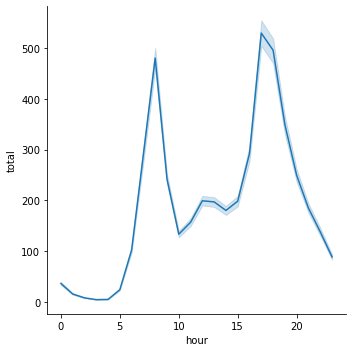

In [11]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
sns.relplot(
    data=bikes[bikes.workingday == 1], 
    x="hour", y="total", 
    kind="line"
)

## Análisis grafico "workingday"=1

Al analizar el numero de alquileres por hora, cuando el dia es laboral, tenemos que en promedio, se presentan dos picos donde mas se alquilan bicicletas, estos son a las 7 de la mañana, y el otro es a las 4 de la tarde, por otro lado, entre las 12 y las 4 de la mañana, se presentan los menores alquileres en promedio, y a partir de las 7 de la noche, comienza un descenso en los alquileres. 

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [12]:
# Celda 3
X = bikes[["hour","workingday"]]
y = bikes["total"]

In [13]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
 # Entrenamos nuestro modelo
regr.fit(X, y)

LinearRegression()

In [14]:
y_pred = regr.predict(X)
y_pred

array([ 67.70595026,  78.19801308,  88.69007591, ..., 292.11175582,
       302.60381864, 313.09588146])

In [15]:
print('Coeficientes: \n', regr.coef_)
print('Intercepto: \n', regr.intercept_)

Coeficientes: 
 [10.49206282  4.07248627]
Intercepto: 
 67.70595026191602


In [16]:
from sklearn.metrics import mean_squared_error, r2_score
# The mean squared error
print("MSE: %.2f" % mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coeficiente de Determinación: %.2f" % r2_score(y, y_pred))

MSE: 27541.26
Coeficiente de Determinación: 0.16


## Interpretación Regresión lineal

Se realiza una regresion lineal multiple, con la variable total como variable respuesta y "hour" y "workingday" como las únicas variables predictoras, obteniendo como resultado un coeficiente de 10.49 para la variable "hour" y de 4.07 para la variable "workingday", intuitivamente, estos resultados se pueden interpretar como:
* Por cada hora que pase, se espera que el el alquiler de bicicletas aumente en 10,49 unidades. 
* Si el dia es no laboral, se espera que el alquiler de bicicletas aumente 4.07 unidades. 

sin embargo, la regresion lineal tiene muchos limitantes para las variables categoricas, ya que no consideran la categoria de cada una de ellas, sino que toma la variable de una forma lineal, lo que hace que estos resultados sean poco confiables. 
Otro punto a considerar, es el bajo ajuste de bondad que presenta el modelo con 0.16, lo que nos confirma lo poco confiable que es realizar una regresion lineal para este tipo de datos.


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [17]:
# Celda 4
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

##Para la variable hour
j = 0

# División de la variable hour en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)

# División de las observaciones usando el punto de corte en la posición 2 de la lista de splits
k=5
filter_l = X.iloc[:, j] < splits[k]

# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
# y_l: la observación tiene un valor menor al punto de corte seleccionado
# y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [22]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Gini index de las observaciones que tienen un valor menor al punto de corte seleccionado
gini_l = gini(y_l)
# Gini index de las observaciones que tienen un valor mayor o igual al punto de corte seleccionado
gini_r = gini(y_r)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Ganancia de la variable 'Hits' en el punto de corte selecionado
gini_impurity(X.iloc[:, j], y, splits[k])

10610.413579790038

In [23]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [24]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 5)
j, split, gain

(0, 8.0, 18268.811823533004)

In [25]:
# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

y.shape[0], y_l.shape[0], y_r.shape[0]

(10886, 3594, 7292)

In [26]:
y.mean(), y_l.mean(), y_r.mean()

(191.57413191254824, 55.437673900946024, 258.6715578716402)

In [28]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Aplicación de la función tree_grow
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': -1,
  'n_samples': 3594,
  'gain': 7207.700659959655},
 'sr': {'y_pred': 1,
  'y_prob': 258.6007677543186,
  'level': 1,
  'split': -1,
  'n_samples': 7292,
  'gain': 7392.920792160614}}

In [29]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree
## Dando  como resultado un arbol de 3 niveles, con 6 nodos finales. Dando un nivel de ganancia maximo de 8546.29.

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'gain': 7207.700659959655,
  'sl': {'y_pred': 1,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'gain': 646.8008927589567,
   'sl': {'y_pred': 1,
    'y_prob': 25.15934475055845,
    'level': 3,
    'split': -1,
    'n_samples': 2684,
    'gain': 382.8088308604629},
   'sr': {'y_pred': 1,
    'y_prob': 75.92778993435448,
    'level': 3,
    'split': -1,
    'n_samples': 455,
    'gain': 2961.6385176407275}},
  'sr': {'y_pred': 1,
   'y_prob': 212.18599562363238,
   'level': 2,
   'split': [1, 1.0],
   'n_samples': 455,
   'gain': 25730.857340927716,
   'sl': {'y_pred': 1,
    'y_prob': 46.63265306122449,
    'level': 3,
    'split': -1,
    'n_samples': 145,
    'gain': 0},
   'sr': {'y_pred': 1,
    'y_p

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [30]:
# Celda 5
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 20)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

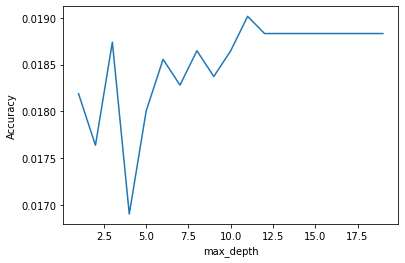

In [31]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [32]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

## Al realizar el arbol de decisión con la libreria sklearn, nos da como resultado, que el mejor accuracy 
## se da con una profundidad de 11, y con un valor de 0.019, lo cual es muy bajo para el modelo. 
## Al comparar con el arbol creado manualmente, observamos la eficiencia de realizarlo con la libreria
## que se encuentra mas optimizada, y da el mejor resultado posible. 


(0.01901543847566575, 11)

In [33]:
# max_depth=11 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=11, random_state=1)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=11, random_state=1)

In [34]:
# Impresión de resultados de desemepeño del árbol de decisión
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.019015
std       0.005761
min       0.005510
25%       0.016085
50%       0.021589
75%       0.022732
max       0.023875
dtype: float64

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [35]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [36]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [37]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [38]:
# Celda 6
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor

max_depth_range = range(1, 21)
accuracy_scores = []
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

count    10.000000
mean      0.646667
std       0.035970
min       0.593333
25%       0.618333
50%       0.653333
75%       0.665000
max       0.713333
dtype: float64

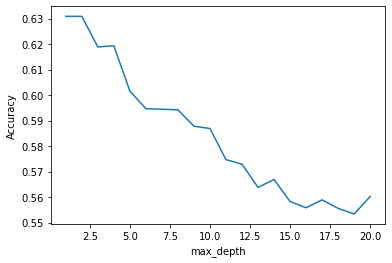

In [39]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

# max_depth=2 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)


# Impresión de resultados de desemepeño del árbol de decisión
pd.Series(cross_val_score(clf, X_test, y_test, cv=10)).describe()

In [40]:
# Definición de 4 modelos diferentes: regresión logística, árbol de decisión,Navie Bayes y k vecinos más cercanos
models = {'lr': LinearRegression(),
          'dt': DecisionTreeRegressor(),
          'nb': GaussianNB(),
          'kn': KNeighborsRegressor()}

In [41]:
# Entrenamiento (fit) de cada modelo
for model in models.keys():
    models[model].fit(X_train, y_train)

In [42]:
y_pred = pd.DataFrame(columns=models.keys())
for model in models.keys():
    y_pred[model] = models[model].predict(X_test)

In [43]:
# Evaluación del error de cada modelo
from sklearn.metrics import mean_squared_error

for model in models.keys():
    print(model,np.sqrt(mean_squared_error(y_pred[model], y_test)))

lr 0.4680724727728638
dt 0.6792152334373349
nb 0.6643292356454993
kn 0.51856211456938


Podemos observar que el modelo que da un mejor desempeño es el de k vecinos mas cercanos con un MSE mas bajo. Entre los modelos de regresion logistica y arbol de decision, el de mejor desempeño es la regresion logistica, con un MSE mas bajo. 

In [44]:
# Evaluación  del error promedio de las predicciones
np.sqrt(mean_squared_error(y_pred.mean(axis=1), y_test))

0.5029034964002977

In [45]:
y_pred["lr"]
Regresion_log=y_pred["lr"]

In [46]:
y_pred["lr"]
Regresion_log=y_pred["lr"]

In [47]:
mean_squared_error(Regresion_log, y_test)

0.21909183976770333

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [50]:
# Celda 7
# Proporciones de las diferentes clases de variable de interés (y)
y.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
1,3000,0.5
0,3000,0.5


In [62]:
#max_depth = None
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(DecisionTreeClassifier( max_depth=None,random_state=0,),
                              n_estimators=100,
                              max_samples=300,
                              bootstrap=True,
                              random_state=42,n_jobs=-1, oob_score=True)

In [63]:
# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('max_depth = None: ',metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

max_depth = None:  0.6567567567567568 0.6613333333333333


In [64]:
#max_depth = 2
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(DecisionTreeClassifier( max_depth=2,random_state=0,),
                              n_estimators=100,
                              max_samples=300,
                              bootstrap=True,
                              random_state=42,n_jobs=-1, oob_score=True)

In [65]:
# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('max_depth = 2: ',metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

max_depth = 2:  0.631578947368421 0.6453333333333333


In [66]:
##100 regresiones logisticas
from sklearn.linear_model import LogisticRegression
clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('100 regresiones logisticas: ',metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

100 regresiones logisticas:  0.6126855600539811 0.6173333333333333


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [77]:
# Celda 8
#max_depth = None
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(DecisionTreeClassifier( max_depth=None,random_state=0,),
                              n_estimators=100,
                              max_samples=300,
                              bootstrap=True,
                              random_state=42,n_jobs=-1, oob_score=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
print('Votación Ponderada - max_depth = None: ',metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

Votación Ponderada - max_depth = None:  0.6631087391594397 0.6633333333333333


In [79]:
#max_depth = 2
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(DecisionTreeClassifier( max_depth=2,random_state=0,),
                              n_estimators=100,
                              max_samples=300,
                              bootstrap=True,
                              random_state=42,n_jobs=-1, oob_score=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
print('Votación Ponderada - max_depth = 2: ',metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))

Votación Ponderada - max_depth = 2:  0.6324549237170597 0.6466666666666666


In [80]:
##100 regresiones logisticas
from sklearn.linear_model import LogisticRegression
clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
print('Votación Ponderada - 100 regresiones logisticas: ',metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test))


Votación Ponderada - 100 regresiones logisticas:  0.6140350877192983 0.6186666666666667


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

### Comparación Votación Mayoritaria y Votación Ponderada

Al comparar el desempeño de ambas metodologias de votación por medio de las métricas de Accuracy y F1-Score, tenemos que en todos los casos, la votacion ponderada presenta levemente un mejor desempeño con respecto a la votacion mayoritaria. 

Al ser un problema de clasificación, ya que contamos con variables categóricas el que la votación ponderada le otorgue un peso diferente a cada arbol, tenemos una ventaja, frente al voto mayoritario, el cual proporciona un voto de 1 a la clase con mayor soporte, y 0 para las demas, dando la misma importancia a cada arbol. Este metodo de votacion mayoritaria tendría una mayor ventaja para problemas de regresion y no de clasificacion como es el caso, y eso explica el mejor desempeño en la metodología de votacion mayoritaria. 

